<a href="https://colab.research.google.com/github/Choi-DODO/SOC-Regional-Inequality/blob/main/GWR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Basic Setting

# To install the libraries permanetly
import os, sys
from google.colab import drive
drive.mount('/content/drive')

from google.colab.data_table import DataTable
DataTable.max_columns = 40

from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [ ]:
!pip3 install xlsxwriter
!pip install scipy
!pip install pysal
!pip install libpysal
!pip install mgwr
!pip install geopandas
!pip install pillow
!pip install seaborn

In [ ]:
#@title Import Libraries
import numpy as np
import pandas as pd
import libpysal as ps
from esda.moran import Moran
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

from matplotlib import cm, colors
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm  # 폰트 관련 용도
import seaborn as sns
import geopandas as gp

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
df   = pd.read_stata('/content/drive/MyDrive/Acsblt2Prc/final_data/sp_panel.dta');
df10 = pd.read_stata('/content/drive/MyDrive/Acsblt2Prc/final_data/sp_cross_10.dta'); df11 = pd.read_stata('/content/drive/MyDrive/Acsblt2Prc/final_data/sp_cross_11.dta')
df12 = pd.read_stata('/content/drive/MyDrive/Acsblt2Prc/final_data/sp_cross_12.dta'); df13 = pd.read_stata('/content/drive/MyDrive/Acsblt2Prc/final_data/sp_cross_13.dta')
df14 = pd.read_stata('/content/drive/MyDrive/Acsblt2Prc/final_data/sp_cross_14.dta'); df15 = pd.read_stata('/content/drive/MyDrive/Acsblt2Prc/final_data/sp_cross_15.dta')
df16 = pd.read_stata('/content/drive/MyDrive/Acsblt2Prc/final_data/sp_cross_16.dta'); df17 = pd.read_stata('/content/drive/MyDrive/Acsblt2Prc/final_data/sp_cross_17.dta')
df18 = pd.read_stata('/content/drive/MyDrive/Acsblt2Prc/final_data/sp_cross_18.dta'); df19 = pd.read_stata('/content/drive/MyDrive/Acsblt2Prc/final_data/sp_cross_19.dta')

In [ ]:
#@title Import Shapefile
shp_path = r'/content/drive/MyDrive/Acsblt2Prc/final_data/map.shp'
shp = gp.read_file(shp_path)
fig, ax = plt.subplots(figsize=(10,10))
shp.plot(ax=ax, **{'edgecolor':'black', 'facecolor':'white'})
shp.centroid.plot(ax=ax, c='black')

In [ ]:
#@title Model Setting
data = df19             ##############

y = data['ln_lprice'].values.reshape((-1,1))
X_old_r = data[['ln_grdp_pc', 'ln_com_pop', 'manu_rate', 'ln_pop_dens', 'old_rate', 'rstrct_rate', 'ln_old_r']].values      ###############
X_old_t = data[['ln_grdp_pc', 'ln_com_pop', 'manu_rate', 'ln_pop_dens', 'old_rate', 'rstrct_rate', 'ln_old_t']].values      ###############
X_u = data[['ln_grdp_pc', 'ln_com_pop', 'manu_rate', 'ln_pop_dens', 'old_rate', 'rstrct_rate', 'ln_utility']].values      ###############

u = data['_CX']
v = data['_CY']

coords = list(zip(u,v))

X_old_r = (X_old_r - X_old_r.mean(axis=0)) / X_old_r.std(axis=0); X_old_t = (X_old_t - X_old_t.mean(axis=0)) / X_old_t.std(axis=0); X_u = (X_u - X_u.mean(axis=0)) / X_u.std(axis=0)

y = y.reshape((-1,1))

y = (y - y.mean(axis=0)) / y.std(axis=0)

In [ ]:
#@title Calibrate GWR model

old_r_selector = Sel_BW(coords, y, X_old_r)
old_r_bw = old_r_selector.search(bw_min=2)
print(old_r_bw)
old_r_results = GWR(coords, y, X_old_r, old_r_bw).fit()

old_t_selector = Sel_BW(coords, y, X_old_t)
old_t_bw = old_t_selector.search(bw_min=2)
print(old_t_bw)
old_t_results = GWR(coords, y, X_old_t, old_t_bw).fit()

u_selector = Sel_BW(coords, y, X_u)
u_bw = u_selector.search(bw_min=2)
print(u_bw)
u_results = GWR(coords, y, X_u, u_bw).fit()

#Prepare GWR results for mapping

#Add GWR parameters to GeoDataframe
shp[['r_1', 'r_2', 'r_3', 'r_4', 'r_5', 'r_6']]  = old_r_results.params[:,0:6]  ########
shp[['t_1', 't_2', 't_3', 't_4', 't_5', 't_6']]  = old_t_results.params[:,0:6]  ########
shp[['u_1', 'u_2', 'u_3', 'u_4', 'u_5', 'u_6']]  = u_results.params[:,0:6]  ########

shp['gwr_ln_old_r']   = old_r_results.params[:,7]                             ########
shp['gwr_ln_old_t']   = old_t_results.params[:,7]                             ########
shp['gwr_ln_utility']   = u_results.params[:,7]                             ########

#Obtain t-vals filtered based on multiple testing correction
filtered_r = old_r_results.filter_tvals(alpha = 0.1)                                   ########
filtered_t = old_t_results.filter_tvals(alpha = 0.1)                                   ########
filtered_u = u_results.filter_tvals(alpha = 0.1)                                       ########

In [ ]:
#@title Summary of Results

# Percentage of significant coefficients
np.round(sum(np.not_equal(filtered_r, 0)) / len(filtered_r), 4) * 100  # array([ 93.93,  34.41,  60.32,  82.19, 100.  ,  61.94,  94.33,  86.23])
np.round(sum(np.not_equal(filtered_t, 0)) / len(filtered_t), 4) * 100  # array([ 97.17,  35.63,  59.92,  76.11, 100.  ,  71.26,  93.93,  81.38])
np.round(sum(np.not_equal(filtered_u, 0)) / len(filtered_u), 4) * 100  # array([ 73.28,  36.84,  59.11,  79.76, 100.  ,  60.73,  93.12,  85.83])

# Percentage of positive coefficients
np.round(sum(np.greater(old_r_results.params, 0)) / len(old_r_results.params), 4) * 100   # array([100.  ,  63.56,  98.79,   0.  , 100.  ,  35.63, 100.  ,  99.6 ])
np.round(sum(np.greater(old_t_results.params, 0)) / len(old_t_results.params), 4) * 100   # array([100.  ,  60.73, 100.  ,   0.4 , 100.  ,  34.41, 100.  ,  93.93])
np.round(sum(np.greater(u_results.params, 0)) / len(u_results.params), 4) * 100   # array([ 95.55,  64.37, 100.  ,   0.4 , 100.  ,  36.03, 100.  ,  96.76])

# Percentage of negative coefficients
np.round(sum(np.less(old_r_results.params, 0)) / len(old_r_results.params), 4) * 100   # array([  0.  ,  36.44,   1.21, 100.  ,   0.  ,  64.37,   0.  ,   0.4 ])
np.round(sum(np.less(old_t_results.params, 0)) / len(old_t_results.params), 4) * 100   # array([ 0.  , 39.27,  0.  , 99.6 ,  0.  , 65.59,  0.  ,  6.07])
np.round(sum(np.less(u_results.params, 0)) / len(u_results.params), 4) * 100   # array([ 4.45, 35.63,  0.  , 99.6 ,  0.  , 63.97,  0.  ,  3.24])

# descriptive stats of coefficients
a = np.round(np.min(old_r_results.params, axis = 0),3)
b = np.round(np.max(old_r_results.params, axis = 0),3)
c = np.round(np.mean(old_r_results.params, axis = 0),3)
d = np.round(np.std(old_r_results.params, axis = 0),3)
pd.DataFrame([a,b,c,d]).transpose()

a = np.round(np.min(old_t_results.params, axis = 0),3)
b = np.round(np.max(old_t_results.params, axis = 0),3)
c = np.round(np.mean(old_t_results.params, axis = 0),3)
d = np.round(np.std(old_t_results.params, axis = 0),3)
pd.DataFrame([a,b,c,d]).transpose()

a = np.round(np.min(u_results.params, axis = 0),3)
b = np.round(np.max(u_results.params, axis = 0),3)
c = np.round(np.mean(u_results.params, axis = 0),3)
d = np.round(np.std(u_results.params, axis = 0),3)
pd.DataFrame([a,b,c,d]).transpose()

# Global R2 VS Loacl R2

old_r_results.adj_R2; old_r_results.localR2
u_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 247
Number of covariates:                                                     8

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             14.201
Log-likelihood:                                                       2.252
AIC:                                                                 11.497
AICc:                                                                14.256
BIC:                                                              -1302.543
R2:                                                                   0.943
Adj. R2:                                                              0.941

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [ ]:
#@title Calibrate MGWR model

mgwr_selector = Sel_BW(coords, y, X_old_r, multi=True)
mgwr_bw = mgwr_selector.search(multi_bw_min=[2])
print(mgwr_bw)
mgwr_results = MGWR(coords, y, X_old_r, mgwr_selector).fit()

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[ 28.  62.  82. 246. 246.  35. 238. 246.]


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#@title Accessibility RANKING

#Ranking the elsaticities
shp.loc[:, 'elas_rank_r'] = shp.loc[:, 'gwr_ln_old_r'].rank(axis=0, method='average', ascending=False)
shp.loc[:, 'elas_rank_t'] = shp.loc[:, 'gwr_ln_old_t'].rank(axis=0, method='average', ascending=False)
shp.loc[:, 'elas_rank_u'] = shp.loc[:, 'gwr_ln_utility'].rank(axis=0, method='average', ascending=False)
shp.info()

# Merging Price Data for Volume Ranking
wow = df19.loc[:, ['land_price']].copy()
shp = pd.concat([shp, wow], axis = 1)

#Calculating each volume
shp.loc[:, 'volume_r'] = shp.loc[:, 'gwr_ln_old_r'].mul(shp.loc[:, 'land_price'])
shp.loc[:, 'volume_t'] = shp.loc[:, 'gwr_ln_old_t'].mul(shp.loc[:, 'land_price'])
shp.loc[:, 'volume_u'] = shp.loc[:, 'gwr_ln_utility'].mul(shp.loc[:, 'land_price'])

#Ranking the elsaticities
shp.loc[:, 'vol_rank_r'] = shp.loc[:, 'volume_r'].rank(axis=0, method='average', ascending=False)
shp.loc[:, 'vol_rank_t'] = shp.loc[:, 'volume_t'].rank(axis=0, method='average', ascending=False)
shp.loc[:, 'vol_rank_u'] = shp.loc[:, 'volume_u'].rank(axis=0, method='average', ascending=False)

# Merging Raw Accessibility Data for Volume Ranking
raw = df19.loc[:, ['road', 'train', 'ac9']].copy()
shp = pd.concat([shp, raw], axis = 1)

#Ranking the elsaticities
shp.loc[:, 'raw_rank_r'] = shp.loc[:, 'road'].rank(axis=0, method='average', ascending=False)
shp.loc[:, 'raw_rank_t'] = shp.loc[:, 'train'].rank(axis=0, method='average', ascending=False)
shp.loc[:, 'raw_rank_u'] = shp.loc[:, 'ac9'].rank(axis=0, method='average', ascending=False)


In [ ]:
#@title Volume VS. Elasticity: Accessibility Figure
#Comparison maps of GWR (road, train, utility) parameter surfaces where the deeper units pertain to higher ranks with higher parameter values

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,30))

ax00 = axes[0, 0]
ax00.set_title('Volume Rank Surface in 2019', fontsize=30)
ax00.set_ylabel('ROAD', fontsize=30)                                                                ############

ax10 = axes[1, 0]
ax10.set_ylabel('TRAIN', fontsize=30)                                                                                ############

ax20 = axes[2, 0]
ax20.set_ylabel('UTILITY', fontsize=30)

ax01 = axes[0, 1]
ax01.set_title('Elasticity Rank Surface in 2019', fontsize=30)               ############

ax11 = axes[1, 1]
ax21 = axes[2, 1]


cmap  = plt.cm.YlOrRd      #Seletion of color type
cmap  = cmap.reversed()    #Reversed order of color

vmin = 1                   #setting min value of colorbar
vmax = 247                 #setting max value of colorbar

sm    = plt.cm.ScalarMappable(cmap=cmap, norm=colors.NoNorm(vmin=vmin, vmax=vmax))                 #generating colorbar

shp.plot('vol_rank_r', cmap=sm.cmap, ax=ax00, **{'edgecolor':'black', 'alpha':.65})           ############

shp.plot('vol_rank_t', cmap=sm.cmap, ax=ax10, **{'edgecolor':'black', 'alpha':.65})           ############

shp.plot('vol_rank_u', cmap=sm.cmap, ax=ax20, **{'edgecolor':'black', 'alpha':.65})           ############

shp.plot('elas_rank_r', cmap=sm.cmap, ax=ax01, **{'edgecolor':'black', 'alpha':.65})          ############

shp.plot('elas_rank_t', cmap=sm.cmap, ax=ax11, **{'edgecolor':'black', 'alpha':.65})          ############

shp.plot('elas_rank_u', cmap=sm.cmap, ax=ax21, **{'edgecolor':'black', 'alpha':.65})          ############

## adjust the subplot layout
fig.tight_layout(h_pad = -1, w_pad = -1)

cbar = fig.colorbar(sm, ax=ax01); cbar.ax.tick_params(labelsize=30); cbar.set_ticks([vmin, 125, vmax]) #importing colorbar
cbar = fig.colorbar(sm, ax=ax11); cbar.ax.tick_params(labelsize=30); cbar.set_ticks([vmin, 125, vmax]) #importing colorbar
cbar = fig.colorbar(sm, ax=ax21); cbar.ax.tick_params(labelsize=30); cbar.set_ticks([vmin, 125, vmax]) #importing colorbar

# Censoring X-Y axis
ax00.get_xaxis().set_visible(False); ax01.get_xaxis().set_visible(False)
ax10.get_xaxis().set_visible(False); ax11.get_xaxis().set_visible(False)
ax20.get_xaxis().set_visible(False); ax21.get_xaxis().set_visible(False)

ax00.get_yaxis().set_visible(True); ax01.get_yaxis().set_visible(False)
ax10.get_yaxis().set_visible(True); ax11.get_yaxis().set_visible(False)
ax20.get_yaxis().set_visible(True); ax21.get_yaxis().set_visible(False)

ax00.tick_params(axis = 'both', which = 'both', length = 0, labelleft = False)
ax10.tick_params(axis = 'both', which = 'both', length = 0, labelleft = False)
ax20.tick_params(axis = 'both', which = 'both', length = 0, labelleft = False)

plt.show()


In [ ]:
#@title Volume VS. Raw: Accessibility Figure
#Comparison maps of GWR (road, train, utility) parameter surfaces where the deeper units pertain to higher ranks with higher parameter values

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,30))

ax00 = axes[0, 0]
ax00.set_title('Accessibility Rank Surface in 2019', fontsize=30)
ax00.set_ylabel('ROAD', fontsize=30)                                                                ############

ax10 = axes[1, 0]
ax10.set_ylabel('TRAIN', fontsize=30)                                                                                ############

ax20 = axes[2, 0]
ax20.set_ylabel('UTILITY', fontsize=30)

ax01 = axes[0, 1]
ax01.set_title('Volume Rank Surface in 2019', fontsize=30)               ############

ax11 = axes[1, 1]
ax21 = axes[2, 1]


cmap  = plt.cm.PuBuGn      #Seletion of color type
cmap  = cmap.reversed()    #Reversed order of color

vmin = 1                   #setting min value of colorbar
vmax = 247                 #setting max value of colorbar

sm    = plt.cm.ScalarMappable(cmap=cmap, norm=colors.NoNorm(vmin=vmin, vmax=vmax))                 #generating colorbar

shp.plot('vol_rank_r', cmap=sm.cmap, ax=ax01, **{'edgecolor':'black', 'alpha':.65})           ############

shp.plot('vol_rank_t', cmap=sm.cmap, ax=ax11, **{'edgecolor':'black', 'alpha':.65})           ############

shp.plot('vol_rank_u', cmap=sm.cmap, ax=ax21, **{'edgecolor':'black', 'alpha':.65})           ############

shp.plot('raw_rank_r', cmap=sm.cmap, ax=ax00, **{'edgecolor':'black', 'alpha':.65})          ############

shp.plot('raw_rank_t', cmap=sm.cmap, ax=ax10, **{'edgecolor':'black', 'alpha':.65})          ############

shp.plot('raw_rank_u', cmap=sm.cmap, ax=ax20, **{'edgecolor':'black', 'alpha':.65})          ############

## adjust the subplot layout
fig.tight_layout(h_pad = -1, w_pad = -1)

cbar = fig.colorbar(sm, ax=ax01); cbar.ax.tick_params(labelsize=30); cbar.set_ticks([vmin, 125, vmax]) #importing colorbar
cbar = fig.colorbar(sm, ax=ax11); cbar.ax.tick_params(labelsize=30); cbar.set_ticks([vmin, 125, vmax]) #importing colorbar
cbar = fig.colorbar(sm, ax=ax21); cbar.ax.tick_params(labelsize=30); cbar.set_ticks([vmin, 125, vmax]) #importing colorbar

# Censoring X-Y axis
ax00.get_xaxis().set_visible(False); ax01.get_xaxis().set_visible(False)
ax10.get_xaxis().set_visible(False); ax11.get_xaxis().set_visible(False)
ax20.get_xaxis().set_visible(False); ax21.get_xaxis().set_visible(False)

ax00.get_yaxis().set_visible(True); ax01.get_yaxis().set_visible(False)
ax10.get_yaxis().set_visible(True); ax11.get_yaxis().set_visible(False)
ax20.get_yaxis().set_visible(True); ax21.get_yaxis().set_visible(False)

ax00.tick_params(axis = 'both', which = 'both', length = 0, labelleft = False)
ax10.tick_params(axis = 'both', which = 'both', length = 0, labelleft = False)
ax20.tick_params(axis = 'both', which = 'both', length = 0, labelleft = False)

plt.show()
#plt.savefig('/content/drive/MyDrive/Acsblt2Prc/results/image.jpg')

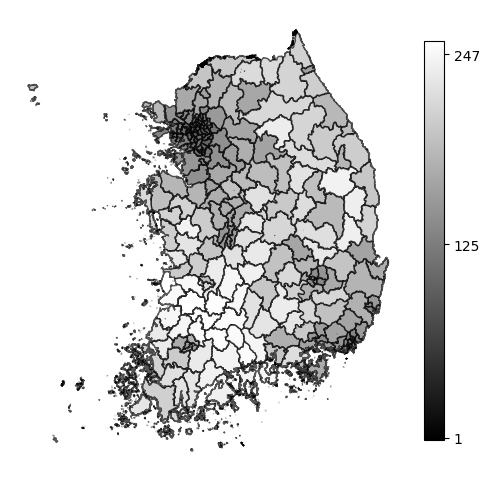

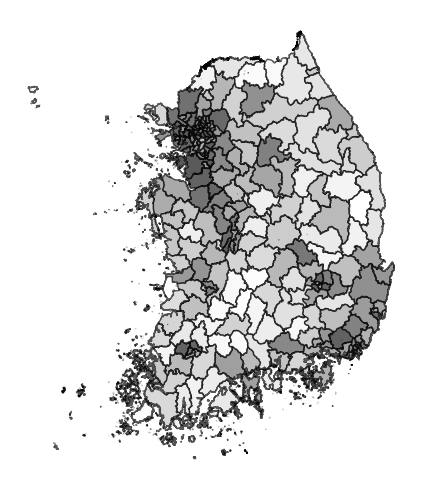

In [ ]:
#@title Figure3: Saving Seperate Map Images

target1 = 'vol_rank_u'
target2 = 'raw_rank_u'

#right column with color bar
fig, axes = plt.subplots(nrows=1, ncols=1,  figsize = (5,5))

cmap  = plt.cm.gist_yarg    #Seletion of color type
cmap  = cmap.reversed()     #Reversed order of color
vmin  = 1                   #setting min value of colorbar
vmax  = 247                 #setting max value of colorbar
sm    = plt.cm.ScalarMappable(cmap=cmap, norm=colors.NoNorm(vmin=vmin, vmax=vmax))                 #generating colorbar

shp.plot(target1, cmap=sm.cmap, ax=axes, **{'edgecolor':'black', 'alpha':.65})           ############

cbar = fig.colorbar(sm, ax=axes, fraction=0.046, pad=0.04);cbar.ax.tick_params(labelsize=10); cbar.set_ticks([vmin, 125, vmax]) #importing colorbar

axes.get_xaxis().set_visible(False); axes.get_yaxis().set_visible(False)            # fill the figure only with map image
plt.gca().spines['right'].set_visible(False); plt.gca().spines['left'].set_visible(False); plt.gca().spines['top'].set_visible(False); plt.gca().spines['bottom'].set_visible(False); # remove outline

fig.tight_layout(h_pad = -1, w_pad = -1)
plt.show()
#plt.savefig('/content/drive/MyDrive/Acsblt2Prc/results/vol_rank_r.jpg')

#left column without color bar
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (5,5))

cmap  = plt.cm.gist_yarg        #Seletion of color type
cmap  = cmap.reversed()    #Reversed order of color
vmin  = 1                   #setting min value of colorbar
vmax  = 247                 #setting max value of colorbar
sm    = plt.cm.ScalarMappable(cmap=cmap, norm=colors.NoNorm(vmin=vmin, vmax=vmax))                 #generating colorbar

shp.plot(target2, cmap=sm.cmap, ax=axes, **{'edgecolor':'black', 'alpha':.65})           ############

axes.get_xaxis().set_visible(False); axes.get_yaxis().set_visible(False)            # fill the figure only with map image
plt.gca().spines['right'].set_visible(False); plt.gca().spines['left'].set_visible(False); plt.gca().spines['top'].set_visible(False); plt.gca().spines['bottom'].set_visible(False); # remove outline

fig.tight_layout(h_pad = -1, w_pad = -1)
plt.show()

In [ ]:
#@title Intercept Figure
#Comparison maps of GWR vs. MGWR parameter surfaces where the grey units pertain to statistically insignificant parameters

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45,20))
ax0 = axes[0]
ax0.set_title('GWR Percent Intercept Surface in 2019 (BW: ' + str(gwr_bw) +')', fontsize=30)              ############
ax1 = axes[1]
ax1.set_title('MGWR Percent Intercept Surface in 2019 (BW: ' + str(mgwr_bw[0]) +')', fontsize=30)         ############
cmap = plt.cm.seismic
gwr_min = shp['gwr_intercept'].min()                                                                      ############
gwr_max = shp['gwr_intercept'].max()                                                                      ############
mgwr_min = shp['mgwr_intercept'].min()                                                                    ############
mgwr_max = shp['mgwr_intercept'].max()                                                                    ############
vmin = np.min([gwr_min, mgwr_min])
vmax = np.max([gwr_max, mgwr_max])

if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1., name='shiftedcmap3')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

shp.plot('gwr_intercept', cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})                 ############
if (gwr_filtered_t[:,0] == 0).any():                                                                                        ############
    shp[gwr_filtered_t[:,0] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})                                  ############

shp.plot('mgwr_intercept', cmap=sm.cmap, ax=ax1, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})                 ############
if (mgwr_filtered_t[:,0] == 0).any():                                                                                        ############
    shp[mgwr_filtered_t[:,0] == 0].plot(color='lightgrey', ax=ax1, **{'edgecolor':'black'})                                  ############

fig.tight_layout()
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=50)
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
plt.show()

In [ ]:
#@title Accessibility Figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45,20))
ax0 = axes[0]
ax0.set_title('GWR Percent Road Access Surface in 2019 (BW: ' + str(gwr_bw) +')', fontsize=40)
ax1 = axes[1]
ax1.set_title('MGWR Percent Road Access Surface in 2019 (BW: ' + str(mgwr_bw[7]) +')', fontsize=40)
cmap = plt.cm.seismic
gwr_min = shp['gwr_ln_old_r'].min()
gwr_max = shp['gwr_ln_old_r'].max()
mgwr_min = shp['mgwr_ln_old_r'].min()
mgwr_max = shp['mgwr_ln_old_r'].max()
vmin = np.min([gwr_min, mgwr_min])
vmax = np.max([gwr_max, mgwr_max])

if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1., name='shiftedcmap4')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

shp.plot('gwr_ln_old_r', cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
if (gwr_filtered_t[:,7] == 0).any():
    shp[gwr_filtered_t[:,7] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})

shp.plot('mgwr_ln_old_r', cmap=sm.cmap, ax=ax1, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
if (mgwr_filtered_t[:,7] == 0).any():
    shp[mgwr_filtered_t[:,7] == 0].plot(color='lightgrey', ax=ax1, **{'edgecolor':'black'})

fig.tight_layout()
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=50)
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
plt.show()

In [ ]:
#@title Consecutive GWR Calibration

road_list = []; train_list = []; util_list = [];

#Declare Variables
depvar         = 'ln_lprice'
indepvar_road  = ['ln_grdp_pc', 'ln_com_pop', 'manu_rate', 'ln_pop_dens', 'old_rate', 'rstrct_rate', 'ln_old_r']
indepvar_train = ['ln_grdp_pc', 'ln_com_pop', 'manu_rate', 'ln_pop_dens', 'old_rate', 'rstrct_rate', 'ln_old_t']
indepvar_util = ['ln_grdp_pc', 'ln_com_pop', 'manu_rate', 'ln_pop_dens', 'old_rate', 'rstrct_rate', 'ln_utility']

#Assign dataset
dataset = [df10, df11, df12, df13, df14, df15, df16, df17, df18, df19]

for dat in dataset:
  #Dependepnt Var
  Y = dat[depvar].values.reshape((-1,1))

  #Independepnt Var
  X_road  = dat[indepvar_road].values
  X_train = dat[indepvar_train].values
  X_util  = dat[indepvar_util].values

  u = dat['_CX']
  v = dat['_CY']

  coords = list(zip(u,v))

  #Model
  road_selector = Sel_BW(coords, Y, X_road);    road_bw = road_selector.search(bw_min=2);   road_model  = GWR(coords, Y, X_road, bw = road_bw, constant = True);
  train_selector = Sel_BW(coords, Y, X_train);  train_bw = train_selector.search(bw_min=2); train_model = GWR(coords, Y, X_train, bw = train_bw, constant = True);
  util_selector = Sel_BW(coords, Y, X_util);    util_bw = util_selector.search(bw_min=2);   util_model  = GWR(coords, Y, X_util, bw = util_bw, constant = True);

  result_road = road_model.fit(); result_train = train_model.fit(); result_util = util_model.fit();

  #Result append
  road_list.append(result_road)
  train_list.append(result_train)
  util_list.append(result_util)

In [ ]:
#@title 결과 저장
table_road = []; table_train = []; table_util = [];

for i in range(0,10):
  road_R2         = pd.DataFrame(road_list[i].localR2.transpose())
  road_params     = pd.DataFrame(road_list[i].params.transpose())
  road_res        = pd.concat([road_R2, road_params], axis = 0)
  road_res.index  = ['localR2', 'constant'] + indepvar_road

  train_R2        = pd.DataFrame(train_list[i].localR2.transpose())
  train_params    = pd.DataFrame(train_list[i].params.transpose())
  train_res       = pd.concat([train_R2, train_params], axis = 0)
  train_res.index = ['localR2', 'constant'] + indepvar_train

  util_R2        = pd.DataFrame(util_list[i].localR2.transpose())
  util_params    = pd.DataFrame(util_list[i].params.transpose())
  util_res       = pd.concat([util_R2, util_params], axis = 0)
  util_res.index = ['localR2', 'constant'] + indepvar_util

  table_road.append(road_res); table_train.append(train_res); table_util.append(util_res);

In [ ]:
#@title Saving Consecutive Output as XLSX file

#pd.DataFrame(road_list[0].filter_tvals(alpha = 0.1).transpose()) #degree of freedom_for_beta = 247 - 7 - 1

table = road_list
ci = 0.01
path = r"/content/drive/MyDrive/Acsblt2Prc/results/tval_road_0.01.xlsx"

writer = pd.ExcelWriter(path, engine = 'xlsxwriter')
for i in range(10):
  pd.DataFrame(table[i].filter_tvals(alpha = ci).transpose()).to_excel(writer, sheet_name = str(i), index = True, index_label = "vars.")
writer.close()


table = table_train
path = r"/content/drive/MyDrive/Acsblt2Prc/results/GWR_train.xlsx"

writer = pd.ExcelWriter(path, engine = 'xlsxwriter')
for i in range(10):
  table[i].to_excel(writer, sheet_name = str(i), index = True, index_label = "vars.")
writer.close()

In [ ]:
#@title GINI/THEIL Function

def gini(x):

    """
    test with this code
    test = np.array([370168, 82701, 51822, 80138, 34846, 37163, 72854, 9262, 381978, 40868, 55192, 101299, 47018, 68878, 103120, 106591, 16947])
    gini(test)
    theil(test)
    """

    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

def theil(x):

  weight = 0
  for i in range(len(x)):
    weight += (x[i]/np.mean(x))*np.log((x[i]/np.mean(x)))
  return weight / len(x)

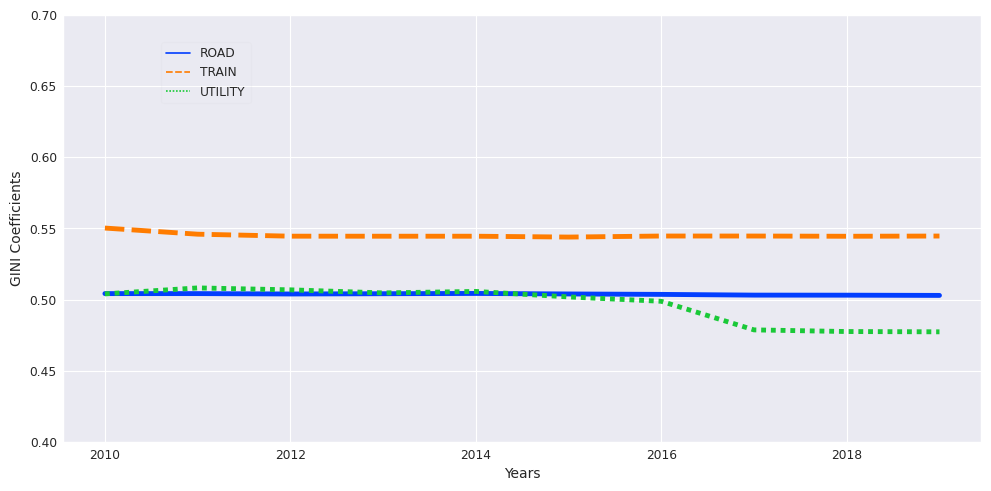

In [ ]:
#@title Figure1: GINI/THEIL Coefficients of raw accessibility

# Data Setting
year = pd.Series(range(2010, 2020, 1), name = 'year')
r_name = pd.Series(['ROAD']*10, name = 'type')
t_name = pd.Series(['TRAIN']*10, name = 'type')
u_name = pd.Series(['UTILITY']*10, name = 'type')

var = 'road' #ac9: Utility / road: old_road /  train: old_train /  ac1: watt_road / ac2: watt_train
r = pd.Series(np.array([gini(df.loc[df['year'] == 2010,var]), gini(df.loc[df['year'] == 2011,var]), gini(df.loc[df['year'] == 2012,var]), gini(df.loc[df['year'] == 2013,var]), gini(df.loc[df['year'] == 2014,var]),
                           gini(df.loc[df['year'] == 2015,var]), gini(df.loc[df['year'] == 2016,var]), gini(df.loc[df['year'] == 2017,var]), gini(df.loc[df['year'] == 2018,var]), gini(df.loc[df['year'] == 2019,var])]), name = 'GINI')
r = pd.concat([r, r_name, year], axis = 1)

var = 'train' #ac9: Utility / road: old_road /  train: old_train /  ac1: watt_road / ac2: watt_train
t = pd.Series(np.array([gini(df.loc[df['year'] == 2010,var]), gini(df.loc[df['year'] == 2011,var]), gini(df.loc[df['year'] == 2012,var]), gini(df.loc[df['year'] == 2013,var]), gini(df.loc[df['year'] == 2014,var]),
                           gini(df.loc[df['year'] == 2015,var]), gini(df.loc[df['year'] == 2016,var]), gini(df.loc[df['year'] == 2017,var]), gini(df.loc[df['year'] == 2018,var]), gini(df.loc[df['year'] == 2019,var])]), name = 'GINI')
t = pd.concat([t, t_name, year], axis = 1)

var = 'ac9' #ac9: Utility / road: old_road /  train: old_train /  ac1: watt_road / ac2: watt_train
u = pd.Series(np.array([gini(df.loc[df['year'] == 2010,var]), gini(df.loc[df['year'] == 2011,var]), gini(df.loc[df['year'] == 2012,var]), gini(df.loc[df['year'] == 2013,var]), gini(df.loc[df['year'] == 2014,var]),
                           gini(df.loc[df['year'] == 2015,var]), gini(df.loc[df['year'] == 2016,var]), gini(df.loc[df['year'] == 2017,var]), gini(df.loc[df['year'] == 2018,var]), gini(df.loc[df['year'] == 2019,var])]), name = 'GINI')
u = pd.concat([u, u_name, year], axis = 1)


fig1 = pd.concat([r, t, u], axis = 0)


# Draw Lineplot
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(10,5))

sns.set_theme(context='paper',      # 매체: paper, talk, poster
              style='darkgrid',     # 기본 내장 테마
              palette='bright',     # 그래프 색 deep, muted, bright, pastel, dark, colorblind
              font='sans-serif',    # 글꼴 종류 mpl.font_manager.get_font_names(): available font list
              font_scale=1)         # 글꼴 크기


sns.lineplot(data=fig1, x = 'year', y ='GINI', hue = 'type', style = 'type', linewidth=3.5, ax = axes)                         # Drawing the subplot
sns.move_legend(axes, loc = "upper left", bbox_to_anchor = (0.10,0.95), frameon = True, title = None, framealpha = 0.1)        # Setting the location of the subplot
axes.set_yticks(np.arange(0.4, 0.75, 0.05))                                                                                    # Setting y axis
axes.tick_params(axis = 'both', which = 'both', length = 1, labelleft = True, labelbottom = True)                              # Whether to show the label, label = tick's label
axes.set_xlabel('Years', fontsize=10); axes.set_ylabel('GINI Coefficients', fontsize=10)                                       # Setting the x-y label
fig.tight_layout(h_pad = -1, w_pad = -1)
plt.show()

In [ ]:
#@title Figure2: GINI/THEIL Coefficients of betas

year = pd.Series(range(2010, 2020, 1), name = 'year')
r_name = pd.Series(['ROAD']*10, name = 'type')
t_name = pd.Series(['TRAIN']*10, name = 'type')
u_name = pd.Series(['UTILITY']*10, name = 'type')


# GINI Coefficients
data = table_road; var = 'ln_old_r'
beta_r = pd.Series(np.array([gini(data[0].loc[var,:]), gini(data[1].loc[var,:]), gini(data[2].loc[var,:]), gini(data[3].loc[var,:]), gini(data[4].loc[var,:]),
                       gini(data[5].loc[var,:]), gini(data[6].loc[var,:]), gini(data[7].loc[var,:]), gini(data[8].loc[var,:]), gini(data[9].loc[var,:])]), name = 'GINI')
beta_r = pd.concat([beta_r, r_name, year], axis = 1)

data = table_train; var = 'ln_old_t'
beta_t = pd.Series(np.array([gini(data[0].loc[var,:]), gini(data[1].loc[var,:]), gini(data[2].loc[var,:]), gini(data[3].loc[var,:]), gini(data[4].loc[var,:]),
                       gini(data[5].loc[var,:]), gini(data[6].loc[var,:]), gini(data[7].loc[var,:]), gini(data[8].loc[var,:]), gini(data[9].loc[var,:])]), name = 'GINI')
beta_t = pd.concat([beta_t, t_name, year], axis = 1)

data = table_util; var = 'ln_utility'
beta_u = pd.Series(np.array([gini(data[0].loc[var,:]), gini(data[1].loc[var,:]), gini(data[2].loc[var,:]), gini(data[3].loc[var,:]), gini(data[4].loc[var,:]),
                       gini(data[5].loc[var,:]), gini(data[6].loc[var,:]), gini(data[7].loc[var,:]), gini(data[8].loc[var,:]), gini(data[9].loc[var,:])]), name = 'GINI')
beta_u = pd.concat([beta_u, u_name, year], axis = 1)

fig2_beta = pd.concat([beta_r, beta_t, beta_u], axis = 0)   # Preapared Dataset for Visualization

In [ ]:
#@title Figure2: GINI/THEIL Coefficients of volumes

elas_road = []; elas_train = []; elas_util = []

for i in range(len(dataset)):
  price       = dataset[i].loc[:,['land_price']]                ;price.reset_index(drop = True, inplace = True)
  road_elas   = table_road[i].loc[['ln_old_r'],:].transpose()   ;road_elas.reset_index(drop = True, inplace = True)
  train_elas  = table_train[i].loc[['ln_old_t'],:].transpose()   ;train_elas.reset_index(drop = True, inplace = True)
  util_elas   = table_util[i].loc[['ln_utility'],:].transpose()   ;util_elas.reset_index(drop = True, inplace = True)


  a = price['land_price'].mul(road_elas['ln_old_r'])
  b = price['land_price'].mul(train_elas['ln_old_t'])
  c = price['land_price'].mul(util_elas['ln_utility'])
  elas_road.append(a)
  elas_train.append(b)
  elas_util.append(c)


year = pd.Series(range(2010, 2020, 1), name = 'year')
r_name = pd.Series(['ROAD']*10, name = 'type')
t_name = pd.Series(['TRAIN']*10, name = 'type')
u_name = pd.Series(['UTILITY']*10, name = 'type')


# GINI Coefficients
data = elas_road; #var = 'ln_road'
vol_r = pd.Series(np.array([gini(data[0]), gini(data[1]), gini(data[2]), gini(data[3]), gini(data[4]),
                       gini(data[5]), gini(data[6]), gini(data[7]), gini(data[8]), gini(data[9])]), name = 'GINI')
vol_r = pd.concat([vol_r, r_name, year], axis = 1)

data = elas_train; #var = 'ln_train'
vol_t = pd.Series(np.array([gini(data[0]), gini(data[1]), gini(data[2]), gini(data[3]), gini(data[4]),
                       gini(data[5]), gini(data[6]), gini(data[7]), gini(data[8]), gini(data[9])]), name = 'GINI')
vol_t = pd.concat([vol_t, t_name, year], axis = 1)

data = elas_util; #var = 'ln_train'
vol_u = pd.Series(np.array([gini(data[0]), gini(data[1]), gini(data[2]), gini(data[3]), gini(data[4]),
                       gini(data[5]), gini(data[6]), gini(data[7]), gini(data[8]), gini(data[9])]), name = 'GINI')
vol_u = pd.concat([vol_u, u_name, year], axis = 1)

fig2_volume = pd.concat([vol_r, vol_t, vol_u], axis = 0) # Preapared Dataset for Visualization
fig2_volume = fig2_volume[fig2_volume['year'] != 2010]

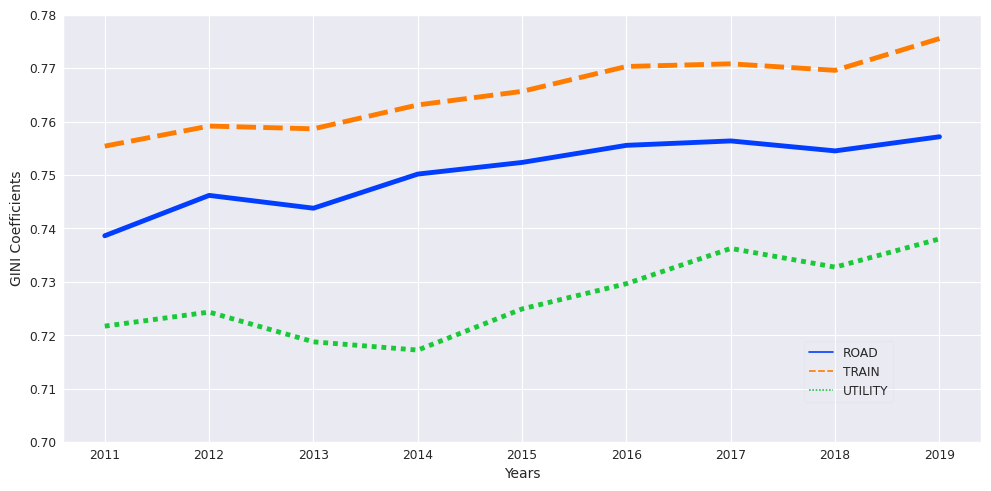

In [ ]:
#@title Figure2: Elasticity VS Volume

#upper figure

# Draw Lineplot
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(10,5))

sns.set_theme(context='paper',      # 매체: paper, talk, poster
              style='darkgrid',     # 기본 내장 테마
              palette='bright',     # 그래프 색 deep, muted, bright, pastel, dark, colorblind
              font='sans-serif',    # 글꼴 종류 mpl.font_manager.get_font_names(): available font list
              font_scale=1)         # 글꼴 크기


sns.lineplot(data=fig2_beta, x = 'year', y ='GINI', hue = 'type', style = 'type', linewidth=3.5, ax = axes)                  # Drawing the subplot
sns.move_legend(axes, loc = "upper left", bbox_to_anchor = (0.10,0.95), frameon = True, title = None, framealpha = 0.1)        # Setting the location of the subplot
axes.set_yticks(np.arange(0.17, 0.41, 0.01))                                                                                    # Setting y axis
axes.tick_params(axis = 'both', which = 'both', length = 1, labelleft = True, labelbottom = True)                              # Whether to show the label, label = tick's label
axes.set_xlabel('Years', fontsize=10); axes.set_ylabel('GINI Coefficients', fontsize=10)                                       # Setting the x-y label
fig.tight_layout(h_pad = -1, w_pad = -1)
plt.show()

# Draw Lineplot
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(10,5))

sns.set_theme(context='paper',      # 매체: paper, talk, poster
              style='darkgrid',     # 기본 내장 테마
              palette='bright',     # 그래프 색 deep, muted, bright, pastel, dark, colorblind
              font='sans-serif',    # 글꼴 종류 mpl.font_manager.get_font_names(): available font list
              font_scale=1)         # 글꼴 크기


sns.lineplot(data=fig2_volume, x = 'year', y ='GINI', hue = 'type', style = 'type', linewidth=3.5, ax = axes)                  # Drawing the subplot
sns.move_legend(axes, loc = "upper left", bbox_to_anchor = (0.80,0.25), frameon = True, title = None, framealpha = 0.1)        # Setting the location of the subplot
axes.set_yticks(np.arange(0.7, 0.78, 0.01))                                                                                    # Setting y axis
axes.tick_params(axis = 'both', which = 'both', length = 1, labelleft = True, labelbottom = True)                              # Whether to show the label, label = tick's label
axes.set_xlabel('Years', fontsize=10); axes.set_ylabel('GINI Coefficients', fontsize=10)                                       # Setting the x-y label
fig.tight_layout(h_pad = -1, w_pad = -1)
plt.show()